##   <font color='Lime'>Import libraries</font> 

In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = r'C:\\Users\diego\OneDrive\Desktop\DS\seismic_segmentation\train'
path_test = r'C:\\Users\diego\OneDrive\Desktop\DS\seismic_segmentation\test'

##   <font color='Lime'>Data Analysis</font> 


In [4]:
train_ids = next(os.walk(os.path.join(path_train,"images")))[2]
test_ids = next(os.walk(os.path.join(path_test,"images")))[2]

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


<ipython-input-5-ebd0e7c9c5c8>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
<ipython-input-5-ebd0e7c9c5c8>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/4000 [00:00<?, ?it/s]

Done!


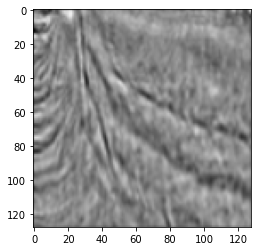

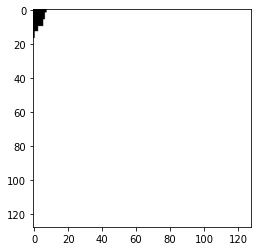

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

##  <font color='Lime'>Train-validation split</font> 

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X_train,Y_train, test_size=0.1,random_state=42)


##  <font color='Lime'>Train the model</font> 


In [11]:
def Intersection_over_Union(y_true, y_pred, threshold=0.5):
    y_pred = K.squeeze(tf.cast(y_pred > threshold,tf.int32), -1)
    y_true = K.cast(y_true[..., 0], K.floatx())
    y_pred = K.cast(y_pred, K.floatx())
    truth_areas = K.sum(y_true, axis=[1, 2])
    pred_areas = K.sum(y_pred, axis=[1, 2])
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.clip(truth_areas + pred_areas - intersection, 1e-9, 128 * 128)
    check = K.map_fn(lambda x: K.equal(x, 0), truth_areas + pred_areas, dtype=tf.bool) #images with no predicted and true salt bodies
    p = intersection / union #ratio for each image
    iou = K.switch(check, p + 1., p) # put 1 for images where no salt bodies were found 

    prec = K.map_fn(lambda x: K.mean(K.greater(x, np.arange(0.5, 1.0, 0.05))), iou, dtype=tf.float32) 
    #does each image have a iou greater than threshold? if so, the image iou is used to calculate the mean
    prec_iou = K.mean(prec)
    return prec_iou

In [24]:
# tf.float32

tf.random.set_seed(42)
#
#import keras
#from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()



#reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)
N=1
#epochs = 100
#batch_size = 32
backbone='resnet34'
base_model = sm.Unet(backbone, activation='sigmoid', encoder_weights='imagenet')# classes=1, activation='sigmoid')
inp = Input(shape=(None, None, N))
s = Lambda(lambda x: x / 255)(inp)
l1 = tf.keras.layers.Conv2D(3, (1, 1))(s) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)


#import tensorflow.keras.metrics 
#model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])# metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
#model.summary()
from tensorflow.keras.optimizers import schedules
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #initial_learning_rate=0.000027#,
    #decay_steps=8000,
    #decay_rate=0.89
    #)


opt = Adam(
    learning_rate=0.000039, # add exponential decay
    epsilon=1e-08)


model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[Intersection_over_Union])# metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

# summarize the model
model.summary()

earlystopper = EarlyStopping(patience=7, verbose=1,restore_best_weights=True)
#tf.cast(X_train, tf.int32)
#tf.cast( Y_train, tf.int32)
#checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)


history=model.fit(X_train, y_train,validation_data = (X_val,y_val), batch_size=14, epochs=19, 
                    callbacks=[earlystopper])
#early_stopping_cb=keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)


#history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=180,
   # batch_size=9,callbacks=[early_stopping_cb])

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, None, None, 1)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 3)     6         
_________________________________________________________________
model_23 (Functional)        (None, None, None, 1)     24456154  
Total params: 24,456,160
Trainable params: 24,438,810
Non-trainable params: 17,350
_________________________________________________________________
Epoch 1/19
258/258 [==============================] - 104s 354ms/step - loss: 0.4656 - Intersection_over_Union: 0.1491 - val_loss: 0.6408 - val_Intersection_over_Union: 0.0000e+00
Epoch 2/19
258/258 [==============================] - 83s 3

##  <font color='Lime'>Save the model and plot accuracy and loss</font> 

C:\Users\diego\OneDrive\Desktop\DS\seismic_segmentation


C:\Users\diego\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


13/13 [==============================] - 2s 103ms/step - loss: 0.1576 - Intersection_over_Union: 0.7673
Accuracy: 76.730770 Loss: 0.157571


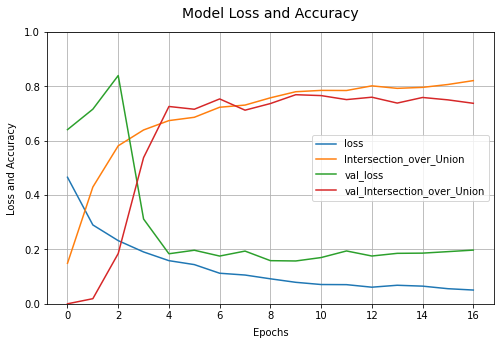

In [25]:
print(os.getcwd())

#save the model
name='CNN_Unet'
#os.mkdir('models/')
if  os.path.exists(os.path.join(os.getcwd(),'models/'))==False:
    os.mkdir('models/')
model.save(os.path.join('models/',name+'.h5'))
model.save_weights(os.path.join('models/',name+'_weights.h5'))
#plt.gca().set_xlim(0,33)
   
    
#loss, accuracy = model.evaluate(X_test,y_test)
if  os.path.exists(os.path.join(os.getcwd(),'plots/'))==False:
    os.mkdir('plots/')

pd.DataFrame(history.history).plot(figsize=(8, 5))

plt.title('Model Loss and Accuracy',fontsize=14,y=1.03 )
plt.grid( True )    

plt.ylabel('Loss and Accuracy',labelpad=7,fontsize=10)    
plt.xlabel('Epochs',labelpad=7,fontsize=10)   
plt.gca().set_ylim(0,1)
plt.savefig(os.path.join('plots/',name+'.png'), dpi=500, bbox_inches='tight',facecolor=(1, 1, 1) )

#evaluate loss and accuracy
loss, accuracy = model.evaluate(X_val,y_val)
#plot loss and accuracy

#plt.gca().set_ylim(0,1)
#plt.grid(True)

#print accuracy    
print('Accuracy: %f' % (accuracy*100),'Loss: %f' % (loss))

##  <font color='Lime'>Accuracy and Loss</font> 

In [26]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 76.731 
 loss : 0.158


In [27]:
# visualize activation functions
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')
#info about optimizers
model.optimizer.get_config()  

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000210DD226430>
   no activation attribute
1 <tensorflow.python.keras.layers.core.TFOpLambda object at 0x00000210C6F50EE0>
   no activation attribute
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000210E233FEE0>
     <function linear at 0x0000020F5C3EAEE0>
3 <tensorflow.python.keras.engine.functional.Functional object at 0x00000210C6F3E940>
   no activation attribute
0   <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000210DD226430>: 
{'batch_input_shape': (None, None, None, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_11'} 

1   <tensorflow.python.keras.layers.core.TFOpLambda object at 0x00000210C6F50EE0>: 
{'name': 'tf.math.truediv_8', 'trainable': True, 'dtype': 'float32', 'function': 'math.truediv'} 

2   <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000210E233FEE0>: 
{'name': 'conv2d_5', 'trainable': True, 'dtype': 'fl

{'name': 'Adam',
 'learning_rate': 3.9e-05,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'amsgrad': False}

C:\Users\diego\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


##  <font color='Lime'>Load the model</font> 

In [28]:
N=1
#epochs = 100
#batch_size = 32
backbone='resnet34'
saved_base_model = sm.Unet(backbone, activation='sigmoid', encoder_weights='imagenet')# classes=1, activation='sigmoid')
inp = Input(shape=(None, None, N))
s = Lambda(lambda x: x / 255)(inp)
l1 = tf.keras.layers.Conv2D(3, (1, 1))(s) # map N channels data to 3 channels
out = base_model(l1)

saved_model = Model(inp, out, name=base_model.name)


from tensorflow.keras.optimizers import schedules

opt = Adam(
    learning_rate=0.000039, # add exponential decay
    epsilon=1e-08)


saved_model.load_weights(os.path.join('models/',name+'_weights.h5'))

saved_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[Intersection_over_Union])

In [29]:
loss, accuracy = saved_model.evaluate(X_val,y_val)

13/13 [==============================] - 2s 51ms/step - loss: 0.1576 - Intersection_over_Union: 0.7673


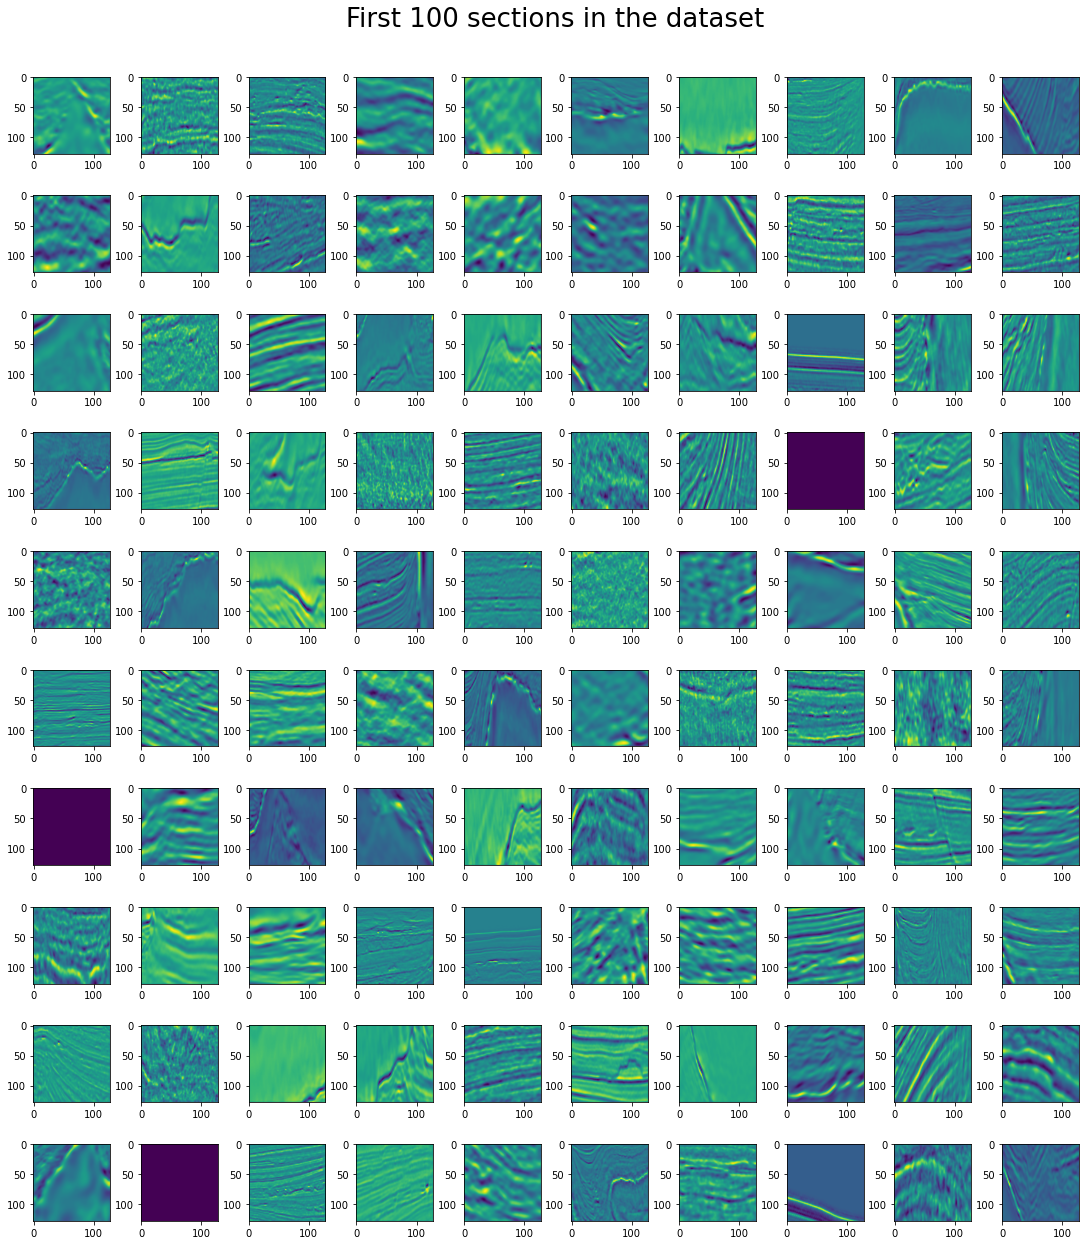

In [135]:
#here I plotted the images based on columns and z_max (defined by the user, but it should be a multiple of the # of columns)
#columns = 20
n_images=100
columns=10


images=X_val[:n_images]


#int(len(images)/columns)

fig,axes=plt.subplots(int(len(images)/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.463, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle(f'First {n_images} sections in the dataset',fontsize=26, x=0.2812,y=0.946)
    #print(j,image)
    axes[int(i/columns), i % columns].imshow(ind)
    #axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns] #.set_title(f'{classes[i]}',pad=10)
#image_plotting(X_test[:1])
plt.savefig(os.path.join('plots/','100_images_in_the_dataset_white.png'), dpi=300,facecolor='w',bbox_inches='tight')

In [ ]:
#here I plotted the images based on columns and z_max (defined by the user, but it should be a multiple of the # of columns)
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#image_plotting(X_test[:1])
#plt.savefig(os.path.join('plots/','Some_MRI_images_in_the_dataset_white.png'), dpi=300,facecolor='w')

##  <font color='Lime'>Test Data</font> 

In [30]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


<ipython-input-30-80c5a58b954f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):


  0%|          | 0/18000 [00:00<?, ?it/s]

Done!


In [31]:

preds_test = model.predict(X_test, verbose=1)

preds_test

563/563 [==============================] - 21s 37ms/step


array([[[[0.2024243 ],
         [0.09120347],
         [0.07608777],
         ...,
         [0.05026831],
         [0.06971066],
         [0.1445071 ]],

        [[0.17307279],
         [0.05480978],
         [0.04205775],
         ...,
         [0.02314427],
         [0.02378357],
         [0.05211195]],

        [[0.12317244],
         [0.03666744],
         [0.03524344],
         ...,
         [0.02024915],
         [0.02053403],
         [0.05680386]],

        ...,

        [[0.18365279],
         [0.07153941],
         [0.07298429],
         ...,
         [0.02184962],
         [0.02689958],
         [0.0854559 ]],

        [[0.13509971],
         [0.0651276 ],
         [0.06660747],
         ...,
         [0.03578483],
         [0.05910614],
         [0.12659551]],

        [[0.24489929],
         [0.10462236],
         [0.11281389],
         ...,
         [0.09423782],
         [0.09534732],
         [0.14467001]]],


       [[[0.16363582],
         [0.06799332],
         [0.05

In [32]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

<ipython-input-32-b9d262d27614>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(preds_test)):


  0%|          | 0/18000 [00:00<?, ?it/s]

In [33]:
preds_test_upsampled[0].shape

(101, 101)

##  <font color='Lime'>Submission</font> 


In [35]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

<ipython-input-35-6ceb950ee2b3>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}


0it [00:00, ?it/s]

In [36]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_unet.csv')